# Retrieve and Unpack Data

In [0]:
import os, sys
from PIL import Image
import pandas as pd
import numpy as np
import json
from time import time
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

from torch import nn
import torch.utils.data as torchdata
import torchvision.models as models

from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import scipy.stats as ss

import logging

# logging.basicConfig(
#     stream=sys.stdout, 
#     level=logging.WARN, 
#     format='[%(asctime)s%(msecs)03d] %(message)s',
#     datefmt='%H:%M:%S.')

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)

IMAGE_SIZE = (128,128)

In [0]:
a = torch.Tensor([1]).cuda()
print(a)

HAS_GPU = True
# if torch.cuda.is_available():
#     HAS_GPU = True

tensor([1.], device='cuda:0')


In [0]:
# !pip install kaggle
# !mkdir .kaggle
# !mkdir data



# token = {"username":"ramg95","key":"f713f68e67eed775abc23149ec728820"}

# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)
    
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle config set -n path -v "/content/data"
# !kaggle competitions download -c humpback-whale-identification

# !unzip -q data/competitions/humpback-whale-identification/test.zip -d data/test/
# !unzip -q data/competitions/humpback-whale-identification/train.zip -d data/train/
# !mv data/competitions/humpback-whale-identification/*.csv data/
# !rm -rf data/competitions

mkdir: cannot create directory ‘.kaggle’: File exists
mkdir: cannot create directory ‘data’: File exists
- path is now set to: /content/data
  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 66.7MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 79.9MB/s]
 99% 1.33G/1.35G [00:11<00:00, 85.3MB/s]
100% 1.35G/1.35G [00:11<00:00, 127MB/s] 
100% 4.14G/4.16G [00:38<00:00, 78.5MB/s]
100% 4.16G/4.16G [00:38<00:00, 116MB/s] 


In [0]:
class Humpback_Whale_Dataset(torchdata.Dataset):
    def __init__(self, data_root , fold='train', validation_fraction=0.1, transforms=None, balance_classes=False):
        
        self.root = data_root
        fold = fold.lower()

        self.train = False
        self.test = False
        self.val = False

        if fold == "train":
            self.train = True
        elif fold == "test":
            self.test = True
        elif fold == "val":
            self.val = True
        else:
            raise RuntimeError("Not train-val-test")
            
        
        # Load data based on fold name
        if self.train or self.val:
            data_info = pd.read_csv(data_root+'data_info.csv', header=0)
            
            self.images = data_info.Image.tolist()
            self.labels = data_info.Id.tolist()
            
            # Data augmentation for class imbalance
            if self.train and balance_classes:
                class_counts = data_info.Id.value_counts()
                images_by_class = {k: g["Image"].tolist() for k,g in data_info.groupby("Id")}                
                low_counts = class_counts[class_counts<=5].index.tolist()
                for label in low_counts:
                    self.labels.extend([label]*4)
                    self.images.extend(np.random.choice(images_by_class[label], 4).tolist())
            
            self.images = np.asarray(self.images)
            self.labels = np.asarray(self.labels)
            print(len(self.images), len(self.labels))
            # Now make a mask for every nth image (training and validation)
            step = int(1/validation_fraction)
            p = np.arange(0, len(self.images), step)
            val_mask = np.zeros(len(self.images), dtype=bool)
            train_mask = np.ones(len(self.images), dtype=bool)
            train_mask[p] = False
            val_mask[p] = True
            
            # set data and label values
            self.data_files = self.images[train_mask] if self.train else self.images[val_mask]
            self.labels = self.labels[train_mask] if self.train else self.labels[val_mask]
            self.data_path = data_root+'train/'
            
            # Load images to memory
            self.data = []
            begin_time = time()
            for i, f in enumerate(self.data_files):
                if i % 1000 == 0:
                    print("Processed %d images in %f seconds" % (i, time()-begin_time))
                img_file = os.path.join(self.data_path, f)
                im = Image.open(img_file).convert('L') \
                .resize(IMAGE_SIZE, resample=Image.LANCZOS)
                self.data.append(im)
            
        elif self.test:
            
            # Directly load names from os.listdir
            self.data = np.array(os.listdir(data_root+'test/'))
            self.data_path = data_root+'test/'
            self.labels = np.zeros(len(self.data))
            
        
        self.length = len(self.data)
        self.transforms = transforms

    def __getitem__(self, index):
        
        image = self.data[index]
        label = self.labels[index]

        if self.test:
            img_file = os.path.join(self.data_path, image)
            image = Image.open(img_file).convert('L').resize(IMAGE_SIZE,resample=Image.LANCZOS)
            image = self.transforms(image)
            image = (self.data[index], image)
        else:
            if self.transforms is not None:
                image = self.transforms(image)
        
        return (image, label)
    
    def __len__(self):
        return self.length
    
    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transforms.__repr__().replace('\n', '\n' + ' ' * len(tmp)))       
        return fmt_str
    

In [0]:
DATA_ROOT = "data/"
TRAIN_BS = 256
TEST_BS = 128
IMAGE_RESIZED_DIM = 100
KNOWN_ONLY = True

# Label Preprocessing
train_csv = pd.read_csv('data/train.csv', header=0)
if KNOWN_ONLY:
    train_csv = train_csv[train_csv.Id != 'new_whale']
LABELER = LabelEncoder()
train_csv.Id = LABELER.fit_transform(train_csv.Id)
train_csv.to_csv('data/data_info.csv', index=False)

TOTAL_CLASSES = len(np.unique(train_csv.Id))


In [0]:
# Image Preprocessing
train_transform = transforms.Compose([
        #transforms.Grayscale(1),
#         transforms.Resize((IMAGE_RESIZED_DIM,IMAGE_RESIZED_DIM)),
#         transforms.CenterCrop((IMAGE_RESIZED_DIM*0.9,IMAGE_RESIZED_DIM*0.9)), 
#         transforms.Resize((IMAGE_RESIZED_DIM,IMAGE_RESIZED_DIM)),
        transforms.RandomResizedCrop(IMAGE_RESIZED_DIM),
        transforms.RandomHorizontalFlip(p=0.33),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_test_transform = transforms.Compose([
        #transforms.Grayscale(1),
        transforms.Resize(IMAGE_RESIZED_DIM),
        transforms.CenterCrop(IMAGE_RESIZED_DIM),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


# Data loading
train_set = Humpback_Whale_Dataset(data_root=DATA_ROOT, 
                                   fold='train', 
                                   validation_fraction = 0.1,
                                   transforms=train_transform,
                                   balance_classes=True)
val_set = Humpback_Whale_Dataset(data_root=DATA_ROOT, 
                                   fold='val', 
                                   validation_fraction = 0.1,
                                   transforms=val_test_transform,
                                   balance_classes=True)


trainloader = torchdata.DataLoader(train_set, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=4)
valloader = torchdata.DataLoader(val_set, batch_size=TEST_BS,
                                         shuffle=False, num_workers=4)

# test loader
test_set = Humpback_Whale_Dataset(data_root=DATA_ROOT, 
                                   fold='test',
                                   transforms=val_test_transform)
testloader = torchdata.DataLoader(test_set, batch_size=TEST_BS,
                                         shuffle=False, num_workers=4)


33181 33181
Processed 0 images in 0.000010 seconds
Processed 1000 images in 15.547883 seconds
Processed 2000 images in 32.644961 seconds
Processed 3000 images in 48.713629 seconds
Processed 4000 images in 64.399019 seconds
Processed 5000 images in 80.029800 seconds
Processed 6000 images in 95.442791 seconds
Processed 7000 images in 112.065125 seconds
Processed 8000 images in 128.618874 seconds
Processed 9000 images in 144.671022 seconds
Processed 10000 images in 160.265365 seconds
Processed 11000 images in 176.803201 seconds
Processed 12000 images in 193.379985 seconds
Processed 13000 images in 209.843293 seconds
Processed 14000 images in 225.770863 seconds


In [0]:
trainloader.dataset

Dataset Humpback_Whale_Dataset
    Number of datapoints: 14127
    Split: train
    Root Location: data/
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(100, 100), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.33)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

In [0]:
valloader.dataset

Dataset Humpback_Whale_Dataset
    Number of datapoints: 1570
    Split: test
    Root Location: data/
    Transforms (if any): Compose(
                             Resize(size=100, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(100, 100))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

In [0]:
testloader.dataset

Dataset Humpback_Whale_Dataset
    Number of datapoints: 7960
    Split: test
    Root Location: data/
    Transforms (if any): Compose(
                             Resize(size=168, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(168, 168))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

# Model Pipelines

In [0]:
def validation(model, valloader):
    
    correct = total = 0.0
    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    model.eval()

    with torch.no_grad():
        for images, labels in valloader:
            if HAS_GPU:
                images = images.cuda()
                labels = labels.cuda()

            # Predict and compute accuracy    
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()


            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

    #class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total #, class_accuracy


def train(model, optimizer, loss_function, trainloader, valloader, num_epochs, validate=True):
    
    model.train()
    for epoch in range(num_epochs):
        correct = total = running_loss = 0.0
        a = time()
        tbar = tqdm_notebook(trainloader)
        for i , (images, labels) in enumerate(tbar):
            # Train here
            if HAS_GPU:
                images = images.cuda()
                labels = labels.cuda()
            
            # Forward, and loss compute
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            
            # Calculate gradients, update parameters
            loss.backward()
            optimizer.step()
            
            # Update train accuracy values
            batch_correct = (torch.argmax(outputs, 1) == labels).sum().float()
            correct += batch_correct
            total += labels.size(0)
            running_loss += loss.item()
            tbar.set_description('Train loss: {0:.3f}'.format(running_loss / (i + 1)))
        
        tbar.close()
        del tbar
        # Normalizing the loss by the total number of train batches
        running_loss/=len(trainloader)
        print("[%d] Took %f seconds.\n"%(epoch+1, time() - a))
        if validate:
            val_accuracy = validation(model, valloader)
            print('val: %d %% \t ' % (val_accuracy))
        print('train accuracy: %f %%, loss: %f\n' % (correct*100/total, running_loss))
        
def test(model, testloader, out_path):
    model.eval()

    total = 0
    df = {
        "Image" : [],
        "Id": []
    }
    for images, labels in testloader:
        image_names, images = images
        
        if HAS_GPU:
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        # print(predicted)
        df['Id'].extend(LABELER.inverse_transform(list(predicted.cpu().numpy())))
        df['Image'].extend(image_names)
        total += labels.size(0)

    df = pd.DataFrame(df)
    df.to_csv(out_path, index=False)
    

In [0]:
#######################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Flatten(),
            nn.Linear(16*12*12, TOTAL_CLASSES//2),
            nn.ReLU(inplace=True),
            nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        )

    def forward(self, x):
        return self.net(x)
    
    
class PreTrainedResNet(nn.Module):
    def __init__(self, num_classes, feature_extracting):
        super(PreTrainedResNet, self).__init__()

        #TODO1: Load pre-trained ResNet Model
        self.resnet18 = models.resnet18(pretrained=True)

        #Set gradients to false
        if feature_extracting:
            for param in self.resnet18.parameters():
                param.requires_grad = False

        #Replace last fc layer
        num_feats = self.resnet18.fc.in_features
        
        #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
        self.resnet18.fc = nn.Linear(num_feats, TOTAL_CLASSES)
    
    def forward(self, x):
        #TODO3: Forward pass x through the model
        x = self.resnet18(x)
        return x

In [0]:
# Hyper-parameters
RESNET_LAST_ONLY = False

In [0]:
# model = BaseNet()
model = PreTrainedResNet(TOTAL_CLASSES, RESNET_LAST_ONLY)
if HAS_GPU:
    model = model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, optimizer, loss_function, trainloader, valloader, 1, validate=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 60925641.64it/s]


NameError: ignored

In [0]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

train(model, optimizer, loss_function, trainloader, valloader, 10, validate=True)

RuntimeError: ignored

In [0]:
val_accuracy = validate(model, valloader)
print('val accuracy: %d %% \t ' % (val_accuracy))

val accuracy: 27 % 	 


In [0]:
HAS_GPU=False
test(model, testloader, DATA_ROOT+'submission.csv')
#torch.cuda.empty_cache()

RuntimeError: ignored

Techniques to apply to data:

Problem: Data is not the same size
1. Vector Quantization
    

*   Pick a 2-D patch_size, and chop image up into patches with/without overlap. 
*   Make a 


2. Downsampling
3. Upsampling


Problem : High dimension , Solution: Dimensionality Reduction
1. PCA
2. Autoencoders?

Problem: Data imbalance Solution: Augmentation
1. Data imbalance is when we have lots of data for one class, but only like 1 example for others. The way we handle this is either to use Machine learning models with data weighting. One common way is oversampling/augmentation.

we can make copies with modifications of the examples in the classes with lower representation. 

In [0]:
LABELER.inverse_transform([711])

# TODO

1. Figure out how to use facial recognition models -- best possible performance
2. Add more preprocessing to augment data by class --
    *   Add more examples of known whales with lower frequency
    *   Possibly add random transforms like we did in the MP - RandomRotate, Resize, HorizontalFlip etc.

3.  Explore other models such as:
    * Train SVM to recognize a unique whale. Train num_classes SVMs.
    * Random Forest Classifiers


MOST PROMISING PIPELINE:

https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78



*   Detection - Draw bounding box around whale, decrease noise
*   Alignment - 








In [0]:
logging.info("Hello world")

(180, 320)


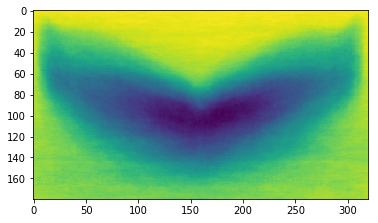

In [0]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

path = DATA_ROOT+'train/'
#fig, ax = plt.subplots(2,1)
#fig.set_size_inches(10,5)
i = 0
ims = []
for f in os.listdir(path)[0:500]:
    im = Image.open(path+f).convert('L')
    im = im.resize((320,180))
    #ax[i].imshow(np.asarray(im))
    ims.append(np.asarray(im)/256)
    i+=1

mean = sum(ims)/len(ims)
print(mean.shape)
plt.imshow(mean)



In [0]:
# An attempt to compute HoG representations

from scipy.ndimage import convolve, correlate

k_x = np.array([[-1,0,1]])
k_y = k_x.T

img = ims[5]
gx = convolve(img, k_x, mode='constant', cval=0.0)
gy = convolve(img, k_y, mode='constant', cval=0.0)

mag,angle = cv2.cartToPolar(gx,gy, angleInDegrees=True)

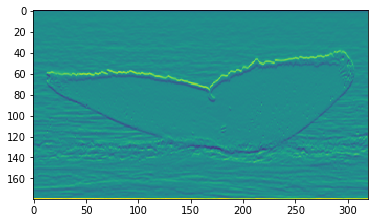

In [0]:
plt.imshow(gx**2 + gy**2)

# Keypoint Extraction, Matching and Nearest Neighbors


In [0]:
# For SIFT
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 1.3MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
import cv2
from cv2.xfeatures2d import SIFT_create

In [0]:
def get_images(img_file, dims):
    im = Image.open(img_file).resize(dims, Image.LANCZOS)
    return np.array(im)

def compute_match_score(im1, im2, topk=10):
    '''
    Use ORB keypoints to compute the match score : average of the topk matches
    '''

    # Create ORB object
    orb = cv2.ORB_create()
    
    # Detect and Compute
    kp1 = orb.detect(im1, None)
    kp1, desc1 = orb.compute(im1, kp1)
    kp2 = orb.detect(im2, None)
    kp2, desc2 = orb.compute(im2, kp2)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(desc1,desc2)
    
    if not matches:
        return -np.inf
    
    if topk and len(matches) > topk:
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)
        matches = matches[:topk]
        return np.mean([x.distance for x in matches])
    
    return np.mean([x.distance for x in matches])


def compute_distance_matrix(train, test):
    '''
    A function to compute distance matrix of average 
    hamming distance of matches between the train and test sets
    '''
    
    D = np.zeros((len(train), len(test)))
    
    for i,train_im in enumerate(train):
        for j, test_im in enumerate(test):
            train_path = 'data/train/'+train_im
            test_path = 'data/train/'+test_im
            D[i][j] = compute_match_score(train_path, test_path)
            
    
    return  D

# Pick a subset of the training set to use as validation
train_csv = pd.read_csv('data/train.csv', header=0)
train_csv = train_csv[train_csv.Id!='new_whale']
class_counts = train_csv.Id.value_counts()
images_by_class = {k: g["Image"].tolist() for k,g in train_csv.groupby("Id")} 

train = []
test = []
train_labels = []
test_labels = []
test_frac = 0.2
for k,v in images_by_class.items():
    s = len(v)
    e = int(test_frac*s)
    train.extend(v[e:])
    test.extend(v[:e])
    train_labels.extend([k]*len(v[e:]))
    test_labels.extend([k]*len(v[:e]))

D = compute_distance_matrix(train,test)


test_labels = np.array(test_labels)
train_labels = np.array(train_labels)
# Now do a manual nearest neighbors
S = D.argsort(axis=0)
predictions = []
for k in range(100):
    for j in range(D.shape[1]):
        predictions.append(ss.mode(train_labels[S[:k,j]]))
    score = (np.array(predictions) == test_labels).sum()/len(predictions)
    print("Score for %d neighbors: %f"%(k, score))

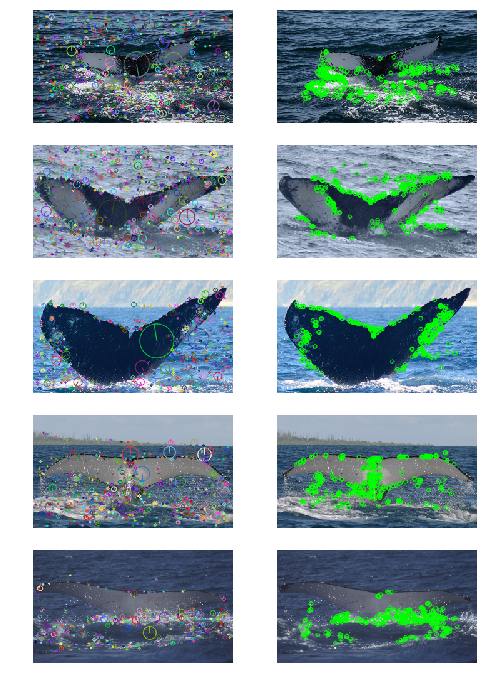

In [0]:
fig, ax = plt.subplots(5,2)
fig.set_size_inches(8,12)
sifts = []
orbs = []
imgs = []
for i in range(5): 
    img1 = get_images(i, (320,180))
    kp = sift.detect(img1, None)
    kp, desc = sift.compute(img1, kp)
    sifts.append((kp,desc))
    img2 = cv2.drawKeypoints(img1, kp, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax[i][0].axis('off')
    ax[i][0].imshow(img2)
    
    orb = cv2.ORB_create()
    kp1 = orb.detect(img1, None)
    kp1, desc1 = orb.compute(img1, kp1)
    orbs.append((kp1,desc1))
    img3 = cv2.drawKeypoints(img1,kp1,color=(0,255,0), outImage=None, flags=0)
    imgs.append(img3)
    ax[i][1].axis('off')
    ax[i][1].imshow(img3)
    

In [0]:
fig, ax = plt.subplots(10,1)
fig.set_size_inches(8,12)
k = 0

        k+=1
        print(k)
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(orbs[i][1],orbs[j][1])
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)
        # Draw first 10 matches.
        img3 = cv2.drawMatches(x,orbs[i][0],y,orbs[j][0],matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        ax[i].axis('off')
        ax[i].imshow(img3)

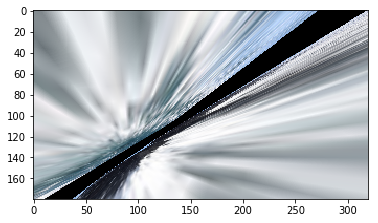

In [0]:
plt.imshow(im1Reg)